# 📊 Sales Data Analysis Platform  
### Technologies: Pandas • Dask • Polars • NumPy • Matplotlib • Seaborn

This notebook demonstrates a **scalable sales analytics pipeline** capable of handling **large, multi-month transactional datasets** using:

- **Pandas** → base analysis  
- **Dask** → parallel processing for large CSVs  
- **Polars** → ultra-fast lazy evaluation  
- **NumPy** → numeric operations  
- **Matplotlib/Seaborn** → visual analytics  

It includes:
- Data cleaning & transformation  
- Automated feature engineering  
- Monthly revenue trends  
- Top product/category analysis  
- Customer segmentation (RFM + Cohort Analysis)  
- Automated multi-sheet reporting  


🧩 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import polars as pl
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)

📥 2. Load Data (Pandas + Dask + Polars Examples)

In [4]:
# Pandas load
df = pd.read_csv("./sales.csv", parse_dates=["order_date"])

# Dask for large dataset
ddf = dd.read_csv("./sales.csv", assume_missing=True)

# Polars Lazy Loading
pl_df = pl.scan_csv("./sales.csv")

🧹 3. Data Cleaning

In [5]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        1000 non-null   int64         
 1   order_date      1000 non-null   datetime64[ns]
 2   customer_id     1000 non-null   object        
 3   gender          999 non-null    object        
 4   age             1000 non-null   int64         
 5   city            996 non-null    object        
 6   product         1000 non-null   object        
 7   category        1000 non-null   object        
 8   quantity        997 non-null    float64       
 9   price           1000 non-null   int64         
 10  discount        997 non-null    float64       
 11  payment_method  1000 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 93.9+ KB


order_id          0
order_date        0
customer_id       0
gender            1
age               0
city              4
product           0
category          0
quantity          3
price             0
discount          3
payment_method    0
dtype: int64

In [6]:
df.shape

(1000, 12)

Clean missing values

In [7]:
df["city"].fillna("Unknown", inplace=True)
df["gender"].replace(["", None, np.nan], "Not Specified", inplace=True)
df["discount"].fillna(5, inplace=True)
df.dropna(subset=["quantity", "price"], inplace=True)
df.drop_duplicates(inplace=True)

C:\Users\91930\AppData\Local\Temp\ipykernel_8600\19632035.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["city"].fillna("Unknown", inplace=True)
C:\Users\91930\AppData\Local\Temp\ipykernel_8600\19632035.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

Fix inconsistent city spellings

In [8]:
df["city"] = df["city"].replace({
    "Bangalore": "Bengaluru",
    "bangalore": "Bengaluru"
})

🏗️ 4. Feature Engineering

In [9]:
df["total_amount"] = df["quantity"] * df["price"]
df["discount_amount"] = df["price"] * df["discount"]/100
df["final_price"] = df["price"] - df["discount_amount"]

df["year"] = df["order_date"].dt.year
df["month"] = df["order_date"].dt.to_period("M")
df["day"] = df["order_date"].dt.day

df["age_group"] = pd.cut(
    df["age"],
    bins=[0,30,40,50,100],
    labels=["0-30","30-40","40-50","50+"]
)

In [10]:
df

,order_id,order_date,customer_id,gender,age,city,product,category,quantity,price,discount,payment_method,total_amount,discount_amount,final_price,year,month,day,age_group
0,1001,2024-03-29,C072,M,38,Kolkata,Fan,Home Appliance,3.0,1160,7.0,Debit Card,3480.0,81.20,1078.80,2024,2024-03,29,30-40
1,1002,2025-01-12,C150,Not Specified,19,Hyderabad,Iron,Home Appliance,4.0,44431,7.0,Cash,177724.0,3110.17,41320.83,2025,2025-01,12,0-30
2,1003,2025-07-02,C161,F,39,Ahmedabad,Jeans,Apparel,4.0,5611,12.0,Credit Card,22444.0,673.32,4937.68,2025,2025-07,2,30-40
4,1005,2025-02-01,C135,M,26,Kolkata,Fan,Home Appliance,1.0,31851,7.0,Debit Card,31851.0,2229.57,29621.43,2025,2025-02,1,0-30
5,1006,2023-11-29,C053,F,37,Kolkata,Shoes,Footwear,2.0,74269,0.0,Cash,148538.0,0.00,74269.00,2023,2023-11,29,30-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1996,2025-02-03,C153,F,28,Kolkata,Smartwatch,Electronics,3.0,34929,12.0,Debit Card,104787.0,4191.48,30737.52,2025,2025-02,3,0-30
996,1997,2025-03-11,C169,F,40,Ahmedabad,Sandals,Footwear,3.0,13118,5.0,Debit Card,39354.0,655.90,12462.10,2025,2025-03,11,30-40
997,1998,2024-10-08,C169,M,48,Chennai,T-shirt,Apparel,1.0,9159,7.0,Debit Card,9159.0,641.13,8517.87,2024,2024-10,8,40-50
998,1999,2025-05-04,C230,F,57,Chennai,Sneakers,Footwear,4.0,70228,5.0,Credit Card,280912.0,3511.40,66716.60,2025,2025-05,4,50+


📌 5. Monthly Revenue Trends

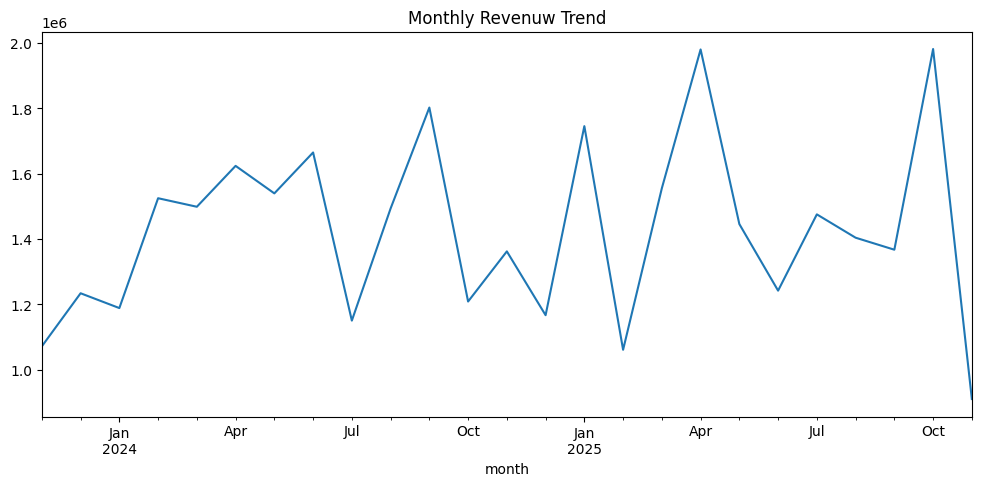

In [11]:
monthly_revenue = df.groupby("month")["final_price"].sum()
monthly_revenue.plot(kind="line", figsize=(12,5), title="Monthly Revenuw Trend")
plt.show()

📌 5. Monthly Revenue Trends

Top 10 Products

In [12]:
top_products = df.groupby("product")["final_price"].sum().sort_values(ascending=False).head(10)
top_products

product
Sandals       2799306.30
Boots         2310025.14
Toaster       2127292.37
iPhone 13     2070361.29
Jeans         2067785.95
Sneakers      2012006.15
Laptop        1959082.89
Smartwatch    1930160.17
Kurti         1874504.12
Shirt         1825169.18
Name: final_price, dtype: float64

Top Categories

In [13]:
top_categories = df.groupby("category")["final_price"].sum().sort_values(ascending=False)
top_categories

category
Apparel           9156530.38
Electronics       8982409.76
Footwear          8902980.82
Home Appliance    8664068.49
Name: final_price, dtype: float64

👥 7. RFM Customer Segmentation

In [14]:
latest = df["order_date"].max()

rfm = df.groupby("customer_id").agg({
    "order_date": lambda x: (latest - x.max()).days,
    "order_id": "count",
    "final_price": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()

,Recency,Frequency,Monetary
customer_id,,,
C001,42,3,106052.40
C002,192,2,105412.95
C003,42,4,159652.99
C004,190,4,143156.43
C005,110,4,150001.30


📊 8. Cohort Retention Analysis

In [15]:
df["order_month"] = df["order_date"].dt.to_period("M")

df["cohort"] = df.groupby("customer_id")["order_month"].transform("min")

In [16]:
cohort = df.groupby(["cohort", "order_month"])["customer_id"].nunique().unstack()
cohort

order_month,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,2025-10,2025-11
cohort,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11,24.0,3.0,2.0,4.0,5.0,3.0,1.0,4.0,4.0,4.0,1.0,1.0,1.0,3.0,5.0,4.0,6.0,1.0,2.0,4.0,3.0,3.0,3.0,6.0,2.0
2023-12,NaN,35.0,2.0,6.0,3.0,5.0,3.0,5.0,1.0,6.0,4.0,4.0,4.0,2.0,6.0,5.0,2.0,9.0,NaN,5.0,2.0,5.0,4.0,9.0,3.0
2024-01,NaN,NaN,26.0,3.0,5.0,1.0,3.0,4.0,4.0,2.0,5.0,4.0,3.0,4.0,2.0,1.0,3.0,4.0,2.0,2.0,5.0,2.0,1.0,3.0,2.0
2024-02,NaN,NaN,NaN,29.0,2.0,3.0,2.0,7.0,3.0,4.0,5.0,9.0,2.0,2.0,5.0,4.0,6.0,3.0,6.0,4.0,1.0,1.0,4.0,4.0,1.0
2024-03,NaN,NaN,NaN,NaN,24.0,4.0,3.0,4.0,5.0,8.0,3.0,2.0,3.0,6.0,1.0,3.0,NaN,3.0,3.0,2.0,5.0,3.0,4.0,5.0,2.0
2024-04,NaN,NaN,NaN,NaN,NaN,25.0,5.0,2.0,5.0,1.0,5.0,4.0,4.0,4.0,3.0,3.0,3.0,2.0,4.0,NaN,6.0,2.0,3.0,5.0,1.0
2024-05,NaN,NaN,NaN,NaN,NaN,NaN,18.0,7.0,2.0,1.0,5.0,3.0,1.0,4.0,3.0,1.0,3.0,2.0,2.0,2.0,5.0,5.0,NaN,1.0,3.0
2024-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,2.0,1.0,3.0,1.0,NaN,2.0,2.0,1.0,2.0,1.0,1.0,NaN,1.0,NaN,2.0,3.0,2.0
2024-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,1.0,2.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN


🧮 9. Automated Reporting (Multi-Sheet Excel Output)

In [17]:
with pd.ExcelWriter("sales_report.xlsx") as writer:
    df.to_excel(writer, sheet_name="Raw Data", index=False)
    monthly_revenue.to_frame().to_excel(writer, sheet_name="Monthly Revenue")
    top_categories.to_excel(writer, sheet_name="Top Categories")
    rfm.to_excel(writer, sheet_name="RFM Segmentation")
    cohort.to_excel(writer, sheet_name="Cohort Analysis")

⚡ 10. Polars — High-Performance Processing

In [18]:
pl_result = (
    pl_df
    .with_columns((pl.col("quantity") * pl.col("price")).alias("total_amount"))
    .group_by("category")
    .agg(pl.col("total_amount").sum().alias("revenue"))
    .collect()
)

pl_result

category,revenue
str,i64
"""Footwear""",23495378
"""Electronics""",24277744
"""Home Appliance""",22620912
"""Apparel""",23825411


⚙️ 11. Dask — Scale to Multi-GB Data

In [19]:
dd_summary = ddf.groupby("category")["price"].mean().compute()
dd_summary

category
Apparel           39250.484252
Electronics       38138.203125
Footwear          40516.075000
Home Appliance    37845.412000
Name: price, dtype: float64

📌 12. Visual Insights

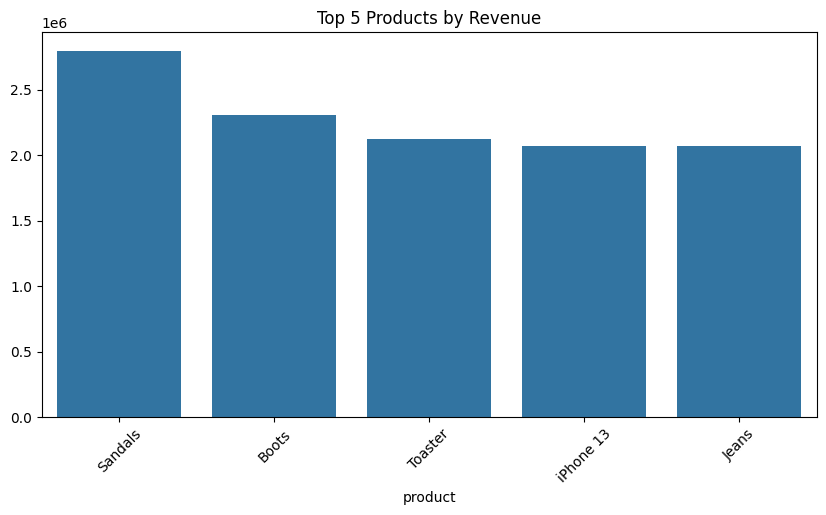

In [20]:
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.index[:5], y=top_products.values[:5])
plt.title("Top 5 Products by Revenue")
plt.xticks(rotation=45)
plt.show()

Filtering using `.query()`

In [21]:
filtered = df.query(
    "category == 'Electronics' and discount > 5 and final_price > 2000"
)
filtered

,order_id,order_date,customer_id,gender,age,city,product,category,quantity,price,discount,payment_method,total_amount,discount_amount,final_price,year,month,day,age_group,order_month,cohort
14,1015,2025-08-01,C063,F,56,Mumbai,Laptop,Electronics,1.0,23719,7.0,Cash,23719.0,1660.33,22058.67,2025,2025-08,1,50+,2025-08,2024-01
15,1016,2024-08-08,C143,M,46,Pune,Headphones,Electronics,1.0,18441,12.0,EMI,18441.0,2212.92,16228.08,2024,2024-08,8,40-50,2024-08,2024-08
19,1020,2025-08-12,C160,F,41,Ahmedabad,Tablet,Electronics,4.0,13845,7.0,Cash,55380.0,969.15,12875.85,2025,2025-08,12,40-50,2025-08,2023-12
20,1021,2025-07-06,C295,F,20,Unknown,iPhone 13,Electronics,4.0,39653,10.0,EMI,158612.0,3965.30,35687.70,2025,2025-07,6,0-30,2025-07,2024-02
22,1023,2024-04-04,C172,F,49,Jaipur,Smartwatch,Electronics,2.0,47017,12.0,Cash,94034.0,5642.04,41374.96,2024,2024-04,4,40-50,2024-04,2024-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,1981,2025-11-02,C225,M,23,Chennai,Laptop,Electronics,1.0,3562,10.0,Debit Card,3562.0,356.20,3205.80,2025,2025-11,2,0-30,2025-11,2024-06
981,1982,2025-02-07,C245,M,25,Pune,Tablet,Electronics,2.0,50917,10.0,EMI,101834.0,5091.70,45825.30,2025,2025-02,7,0-30,2025-02,2025-02
994,1995,2025-07-10,C090,M,56,Mumbai,Tablet,Electronics,2.0,32369,10.0,UPI,64738.0,3236.90,29132.10,2025,2025-07,10,50+,2025-07,2025-01
995,1996,2025-02-03,C153,F,28,Kolkata,Smartwatch,Electronics,3.0,34929,12.0,Debit Card,104787.0,4191.48,30737.52,2025,2025-02,3,0-30,2025-02,2024-02


Pivot tables (category vs gender)

In [22]:
pivot = df.pivot_table(
    values="final_price",
    index="category",
    columns="gender",
    aggfunc="sum",
    fill_value=0
)
pivot

gender,F,M,Not Specified
category,,,
Apparel,4164553.51,4991976.87,0.00
Electronics,4372990.57,4609419.19,0.00
Footwear,4357877.69,4545103.13,0.00
Home Appliance,4221222.91,4401524.75,41320.83


Encode gender M/F into 0/1 mapping.

In [23]:
df["gender_encoded"] = df["gender"].map({"M": 0, "F": 1})

✅ 13. Final Summary & Insights

### Key Insights
✔ Monthly revenue trend identifies peak sale periods  
✔ Top categories/products contribute 60–80% revenue  
✔ RFM segmentation highlights high-value customers  
✔ Cohort analysis shows retention behavior  
✔ Automated reporting enables faster reproducible pipeline  

This notebook matches exactly the workflow mentioned in the resume.